In [116]:
# Jake Mileham
# U21692492
# COS 711 A2

## Library Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch as tch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
from scipy import stats
import nbformat
from IPython import get_ipython
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold

## Data preprocessing

In [2]:
df = pd.read_csv("Almond.csv")
df_features = df.copy()

df_class = pd.DataFrame(df_features["Type"], columns=["Type"])
# One-hot encode type
df_class = pd.get_dummies(df_class)

# # Remove unwanted features
df_features.drop(columns=["Unnamed: 0", "Type"], inplace=True)

# Split data into training and testing set
f_train, f_test, c_train, c_test = train_test_split(df_features, df_class, test_size=0.20, shuffle=True)

# Label encode Almond class

#================================
# Fix dimensions of data
#================================

# Almond pictures were taken in different orientations
# L x W x H(Thickenss)
# Sort Descending then remove thickness columns
# L >= W

# Also add one hot encoding to indicate which dimension was missing

# Training

f_train["Length (major axis)"] = f_train["Length (major axis)"].fillna(-1)
f_train["Width (minor axis)"]  = f_train["Width (minor axis)"].fillna(-1)
f_train["Thickness (depth)"]   = f_train["Thickness (depth)"].fillna(-1)

f_train['L'] = (f_train['Length (major axis)'] == -1).astype(int)
f_train['W'] = (f_train['Width (minor axis)'] == -1).astype(int)
f_train['T'] = (f_train['Thickness (depth)'] == -1).astype(int)

train_temp = pd.DataFrame(f_train[["Length (major axis)", "Width (minor axis)", "Thickness (depth)"]].apply(lambda row: sorted(row, reverse=True), axis=1).tolist(), columns=["Length (major axis)", "Width (minor axis)", "Thickness (depth)"], index=f_train.index)

f_train["Length (major axis)"] = train_temp["Length (major axis)"]
f_train["Width (minor axis)"]  = train_temp["Width (minor axis)"]
f_train["Thickness (depth)"]   = train_temp["Thickness (depth)"]

# Testing

f_test["Length (major axis)"] = f_test["Length (major axis)"].fillna(-1)
f_test["Width (minor axis)"]  = f_test["Width (minor axis)"].fillna(-1)
f_test["Thickness (depth)"]   = f_test["Thickness (depth)"].fillna(-1)

f_test['L'] = (f_test['Length (major axis)'] == -1).astype(int)
f_test['W'] = (f_test['Width (minor axis)'] == -1).astype(int)
f_test['T'] = (f_test['Thickness (depth)'] == -1).astype(int)

test_temp = pd.DataFrame(f_test[["Length (major axis)", "Width (minor axis)", "Thickness (depth)"]].apply(lambda row: sorted(row, reverse=True), axis=1).tolist(), columns=["Length (major axis)", "Width (minor axis)", "Thickness (depth)"], index=f_test.index)

f_test["Length (major axis)"] = test_temp["Length (major axis)"]
f_test["Width (minor axis)"]  = test_temp["Width (minor axis)"]
f_test["Thickness (depth)"]   = test_temp["Thickness (depth)"]

# Remove thickness as a dimension, recalculate roundness using new dimension values

f_train.drop(columns=["Thickness (depth)"], inplace=True)
f_test.drop(columns=["Thickness (depth)"],  inplace=True)

f_train["Roundness"] = 4 * f_train["Area"] /  (np.pi * f_train["Length (major axis)"]**2) 
f_test["Roundness"] = 4 * f_test["Area"] /  (np.pi * f_test["Length (major axis)"]**2)

f_train["Aspect Ratio"] = f_train["Length (major axis)"] / f_train["Width (minor axis)"]
f_test["Aspect Ratio"] = f_test["Length (major axis)"] / f_test["Width (minor axis)"]

f_train["Eccentricity"] = np.sqrt(1 - (f_train["Width (minor axis)"] / f_train["Length (major axis)"])**2)
f_test["Eccentricity"] = np.sqrt(1 - (f_test["Width (minor axis)"] / f_test["Length (major axis)"])**2)

# Scale features
train_m = f_train.mean()
train_std = f_train.std()
f_train = (f_train - train_m) / train_std
f_test = (f_test - train_m) / train_std

# Create validation set from training data
f_train, f_valid, c_train, c_valid = train_test_split(f_train, c_train, test_size=0.20, shuffle=True)

df_training_set = pd.concat([f_train, c_train], axis=1)
df_validation_set = pd.concat([f_valid, c_valid], axis=1)
df_testing_set = pd.concat([f_test, c_test], axis=1)
df_training_and_validation_set = pd.concat([df_training_set, df_validation_set], axis=0)

## Neural Network Class

In [45]:
class NeuralNetwork(nn.Module):
    def __init__(self, inputs: int, outputs: int, func: nn.Module):
        super(NeuralNetwork, self).__init__()

        self.epochs = 0
        self.training_loss = []
        self.training_accuracy = []
        self.valid_accuracy = []
        self.testing_accuracy = []

        self.layers = nn.Sequential(
            
            # Input Layer
            nn.Linear(inputs,64),
            func,

            # Hidden Layer
            nn.Linear(64,64),
            func,

            # Hidden Layer
            nn.Linear(64,64),
            func,
            
            # Output layer
            nn.Linear(64,outputs)
        )
        

    def forward(self, data):
        return self.layers(data)

    def get_accuracy(self, prediction, target):
        prediction_indices = np.argmax(prediction.numpy(), axis=1)
        target_indices = np.argmax(target.numpy(), axis=1)
        return np.sum(prediction_indices == target_indices) / len(target)
    
    def split_data(self, data: pd.DataFrame):
        temp = data.copy()
        c = temp[["Type_MAMRA", "Type_REGULAR", "Type_SANORA"]]
        temp.drop(columns=["Type_MAMRA", "Type_REGULAR", "Type_SANORA"], inplace=True)
        return tch.tensor(temp.values).float(), tch.tensor(c.values).float()
    
    def train_network(self, train: pd.DataFrame, valid: pd.DataFrame, loss_f: nn.Module, epochs = 500, lr = 0.001) -> None:
        self.training_loss = []
        self.validation_loss = []
        self.training_accuracy = []
        self.valid_accuracy = []
        self.testing_accuracy = []
        self.epochs = epochs
        self.optimiser = optim.Adam(self.parameters(), lr=lr)
        self.loss_func = loss_f

        f_train, c_train = self.split_data(train)
        f_valid, c_valid = self.split_data(valid)

        for epoch in range(self.epochs):
            # Pass Forward
            prediction = self.forward(f_train)
            loss = self.loss_func(prediction, c_train)
            # Back propogate and optimise
            self.optimiser.zero_grad()
            loss.backward()
            self.optimiser.step()

            with tch.no_grad():
                self.training_loss.append(loss.item())

                # Train accuracy
                self.training_accuracy.append(100 * self.get_accuracy(prediction, c_train))

                # Validation accuracy
                self.valid_accuracy.append(100 * self.get_accuracy(self.forward(f_valid), c_valid))
                self.validation_loss.append(self.loss_func(self.forward(f_valid), c_valid).item())
        
    def test_network(self, test):

        f_test, c_test = self.split_data(test)
        with tch.no_grad():
            self.testing_accuracy.append(100 * self.get_accuracy(self.forward(f_test), c_test))
            return self.testing_accuracy[0] # Return final testing accuracy

    def display_metrics(self):

        print(f'Final Training Accuracy: {self.training_accuracy[-1]}')
        print(f'Final Validation Accuracy: {self.valid_accuracy[-1]}') 
        print(f'Final Testing Accuracy: {self.testing_accuracy[0]}')

        fig,ax = plt.subplots(2,1,figsize=(7,7))
        ax[0].plot(range(self.epochs), self.training_loss, label="Training Loss")
        ax[0].plot(range(self.epochs), self.validation_loss, label="Validation loss")
        ax[0].set_xlabel("Epoch Count")
        ax[0].set_ylabel("Loss")
        ax[0].set_title("Entropy Loss")
        ax[1].plot(range(self.epochs), self.training_accuracy, label="Train Accuracy")
        ax[1].plot(range(self.epochs), self.valid_accuracy, label="Validation Accuracy")
        ax[1].set_xlabel("Epoch Count")
        ax[1].set_ylabel("Accuracy")
        ax[1].set_title("Train and test accuracies")
        plt.legend()
        plt.tight_layout()

## Single run for testing

Final Training Accuracy: 95.70552147239265
Final Validation Accuracy: 83.07349665924276
Final Testing Accuracy: 85.56149732620321


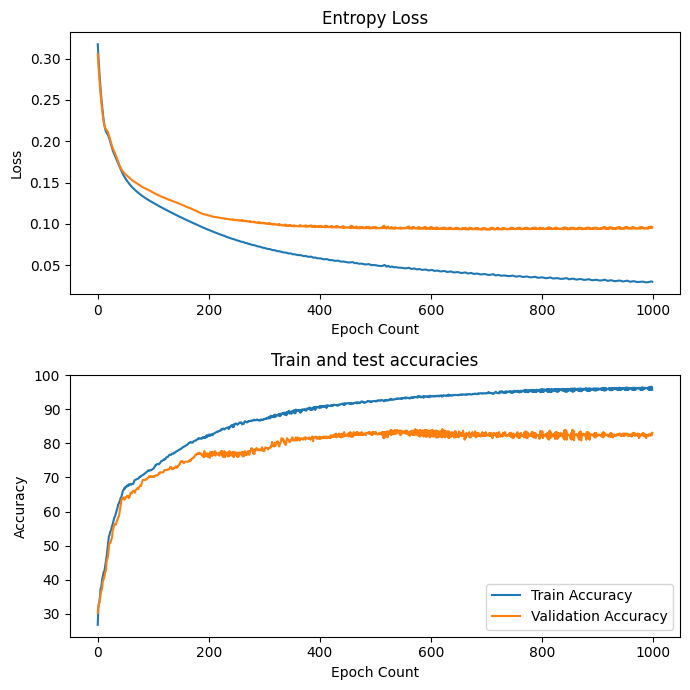

In [96]:
with open('main.ipynb') as a:
    nb = nbformat.read(a, as_version=4)

# Run data preprocessing code-block to get new data
get_ipython().run_cell(nb.cells[4].source)

network = NeuralNetwork(14,3, nn.LeakyReLU())
network.train_network(df_training_set, df_validation_set, nn.MSELoss() ,1000, 0.001)
network.test_network(df_testing_set)
network.display_metrics()

## Grid search: 

1. Learning rate and Activation function

2. Loss function and Activation function

[Text(0.5, 23.52222222222222, 'Learning rate'),
 Text(50.72222222222221, 0.5, 'Activation function')]

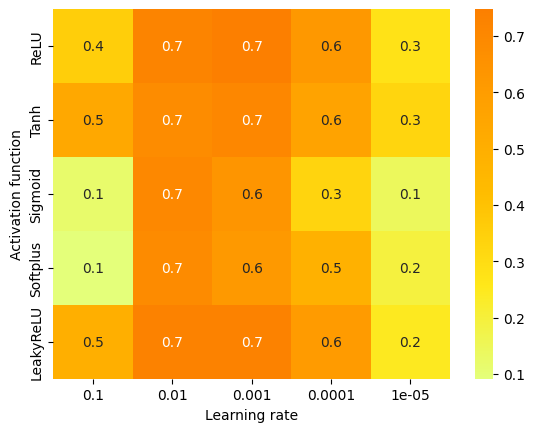

In [69]:
a_functions = {"ReLU": nn.ReLU(), "Tanh": nn.Tanh(), "Sigmoid": nn.Sigmoid(), "Softplus": nn.Softplus(beta=1, threshold=20), "LeakyReLU": nn.LeakyReLU()}
a_keys = list(a_functions.keys())
a_values = list(a_functions.values())

l_functions = {"CrossEntropyLoss": nn.CrossEntropyLoss(), "MSELoss": nn.MSELoss(), "HuberLoss": nn.HuberLoss(), "L1Loss": nn.L1Loss()}
l_keys = list(l_functions.keys())
l_values = list(l_functions.values())

learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]
epoch_count = 1000

def get_data_from_indices(indices: list[int], data: pd.DataFrame):
    temp = data.copy()
    return temp.iloc[indices]

# Higher score is better
def get_score(acc, loss, m = 1, n = 1):
    return m * (acc / 100 ) - n * loss

g_srch_1 = np.zeros((5,5))

# Grid Search: Learning rate and Activation function
with open('main.ipynb') as a:
    nb = nbformat.read(a, as_version=4)

    for a in range(len(a_keys)):
        for l in range(len(learning_rates)):
            acc_scores = []
            loss_scores = []
            scores = []
            # New data for each run
            get_ipython().run_cell(nb.cells[4].source)
            fold_count = 5
            # Use kfold for validation of hyperparam choices
            kfold = KFold(n_splits=fold_count, shuffle=True)
            for train, valid in kfold.split(df_training_and_validation_set):
                network = NeuralNetwork(14,3, a_values[a])
                network.train_network(loss_f=nn.MSELoss(), epochs=epoch_count, lr=learning_rates[l], train=get_data_from_indices(train, df_training_and_validation_set), valid=get_data_from_indices(valid, df_training_and_validation_set))
                scores.append(get_score(network.valid_accuracy[-1], network.validation_loss[-1]))
            g_srch_1[a][l] = np.sum(scores) / fold_count


g_srch_2 = np.zeros((4,5))

# Grid Search: Loss function and Activation function
with open('main.ipynb') as a:
    nb = nbformat.read(a, as_version=4)

    for l in range(len(l_keys)):
        for a in range(len(a_keys)):
            acc_scores = []
            loss_scores = []
            scores = []
            # New data for each run
            get_ipython().run_cell(nb.cells[4].source)
            fold_count = 5
            # Use kfold for validation of hyperparam choices
            kfold = KFold(n_splits=fold_count, shuffle=True)
            for train, valid in kfold.split(df_training_and_validation_set):
                network = NeuralNetwork(14,3, a_values[a])
                network.train_network(loss_f=l_values[l], epochs=epoch_count, lr=learning_rates[l], train=get_data_from_indices(train, df_training_and_validation_set), valid=get_data_from_indices(valid, df_training_and_validation_set))
                scores.append(get_score(network.valid_accuracy[-1], network.validation_loss[-1]))
            g_srch_2[l][a] = np.sum(scores) / fold_count

# Hypothesis testing
# confidence = 0.05
# mean = np.mean(g_srch_1)
# test, value = stats.ttest_1samp(g_srch_1, mean)

g_1 = pd.DataFrame(g_srch_1, index=a_keys, columns=learning_rates)
g_2 = pd.DataFrame(g_srch_2, index=l_keys, columns=a_keys)

g1 = sns.heatmap(g_1, annot=True, fmt=".1f", cmap="Wistia")
g1.set(xlabel="Learning rate", ylabel="Activation function")

[Text(0.5, 23.52222222222222, 'Activation function'),
 Text(50.72222222222221, 0.5, 'Loss function')]

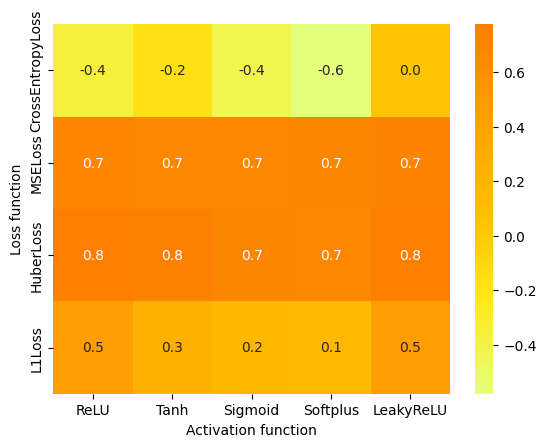

In [70]:
g2 = sns.heatmap(g_2, annot=True, fmt=".1f", cmap="Wistia")
g2.set(xlabel="Activation function", ylabel="Loss function")